In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# High Performance Computing - Exercise 2c 
## The mandelbrot set function

The requirement for the following exercise is to write a code that produces an image representing a Mandelbrot set. 

Each pixel of the image corresponds to a point $c$ of the complex plane. The value of the pixel is $0$ if point $c$ belongs to the Mandelbrot set - black colour in the grey scale - and it is a certain value $I$ if it does not belong to the set. This latter value will correspond to another colour on the scale taken into consideration. 

To be more specific, the value $I$ corresponds to the number of iterations necessary for the point $c$ to be classified as not belonging to the Mandelbrot set.
Here, we give a brief overview of how we determine mathematically whether $c$ belongs to the set or not.  
The Mandelbrot set is the set of points $c$ for which the sequence obtained by iterating the following function is bounded:
$$
f_c(z) = z^2 + c
$$
Where $c = x + iy$ and $z_0 = 0$.  
Thus, the condition to determine whether a point is in the set $M$ is:
$$
|z_n = f_c^n(0)| < 2
$$ or 
$$ 
n > I_{max}
$$  
with $I_{max}$ is a parameter that sets the maximum number of iterations after which we consider the point belonging to the set.

## Structure of the code

From a computational point of view, this problem can be parallelized. Thus, the code presented here consider an hybrid approach that uses both MPI standard and openMP library.  
We perform a domain decomposition of the problem where sections of the image are assigned to different processes and each process divide computations among its threads. 
The code works through the following functions:
- a ***write_pgm_image*** function that outputs the image into a .pgm format;
- a ***mandelbrot*** function that determines whether $c$ belongs to $M$;
- a ***generate_gradient*** function that assigns to each pixel the output of the *mandelbrot* function after computing the $c$ value of interest;
- a ***main*** function that reads input arguments, allocates memory for the image and calls the other functions.  
MPI parallelization is performed at the *main* function level, while openMP parallelization is performed in the *generate_function*.  
The program executable takes as arguments the values $xsize, ysize, x_L, y_L, x_R, y_R, I_{max}$, where $xsize$ and $ysize$ represents dimensions of the image, $x_L$ and $y_L$ ($x_R$ and $y_R$) are respectively the real and imaginary parts of the bottom left (top right) point of the complex plane, and $I_{max}$ the number of maximum iterations. The program is thus compiled and run as follows:  

![Mandelbrot set function](execution.png)  

And, given those specific parameters, it outputs the following image:

![Mandelbrot set](mandelbrot.png)  

We are going through each section of the code in the following paragraphs.  

### Serial code

The *write_pgm_image* and *mandelbrot* functions are serial sections of the code since they are performed by process of rank 0 and a single thread respectively.  
Furthermore, while running the code locally to test it, the *gmon.out* output file obtained by profiling resulted in the *mandelbrot* function being the most expensive call, counting for about the 98% of computational time resource.

![Mandelbrot set function](mand_function.png)

We can see that the function takes as input the point $c$ and the value of $I_{max}$. It counts the number of iterations $n$ of the the function $f_c^n(z)$ and outputs $n$ if the point does not belong to the set $M$ or $0$ otherwise. So, this function strictly depends on the value of $I_{max}$: the higher the value, the most expensive the call.  

### MPI

The MPI standard is applied to the main function of the code.  
Here, after initialization, we define the group of communicating processes and read the arguments of the executable. Then, we divide the image in different portions whose size depends on whether there is a remainder of the division between the ysize and the total number of processes. In this way, the remainder is distributed among different processes without important load imbalance. Basically, each one receives a portion of the array that we allocate in the memory to store pixels' values in a round-robin order.  
Each process computes a local image corresponding to its assigned portion through the *generate_gradient* function.  
Eventually, process corresponding to rank $0$ gathers all local images and uses the *write_pgm_function* to construct and output the final image representing the Mandelbrot set. 
The function called to gather the image is *MPI_Gatherv()* since portions vary in size to the distribution of the remainder.  

![MPI_Gatherv() function](Gatherv.png)


### OpenMP

Each process computes its local_image through the *generate_gradient()* function that is furthermore distributed among threads. Threads number is specified in the slurm file used to run the program through the environment variable *OMP_NUM_THREADS*.    

At first, we tried to open a parallel region only before the for loop and added a *schedule(dynamic)* attribute in order to counterbalance the fact that for points in the mandelbrot set, the number of iteration is by far greater than the one of points not belonging to the region. The code was not scaling but we kept a copy of it in the github repository.

Secondly, we tried to implement a sort of nested parallel region. The outer region assigned its portion of the image to each thread based on the thread's id number. The *parallel for* region was assigning to those same threads the computational work in a dynamic schedule as before. Although it looks to be a nested parallel region, it was not because it wasn't activated through it's corresponding environment variable and thus, the number of threads per process used in the outer and inner regions was the same. The code was still not scaling.

At last, I decided to use only the outer parallel region but I got again computational time results that were not scaling.  
In the scalability section of this report, we present the mentioned results.

## Optimization

During implementation of the serial code, we gave relevance to the optimization of the program.  
In particular, we took into consideration different optimization techniques and compared results in order to write an efficient coding structure.  
- The for cycle inside the *generate_gradient* function performed better with hoisting the expression computing the imaginary part of the complex value instead of using a collapse() attribute.
- Use of conditional branches gave very similar results with respect to not using them.
- We tried to apply unrolling to the for cycle and it performed far better than the original code - about half of the computational time - . We decided not to use it because the image obtained was far more blurred as shown below. 
- The compiler used has the *--march=native* function set.

![MPI_Gatherv() function](mandelbrotUnroll.png)

## Scalability

Now we can present results for scalability.  
In both cases, we used the THIN node on ORFEO and run the program with a maximum of 24 MPI tasks for MPI scalabilty or 24 threads for OMP scalability.  

Since, we didn't obtained scaling results in computational time for OMP scalability, I will not show any graph with respect to it.  
As follows, we can see scalability for MPI tasks keeping fixed to 1 the OMP_NUM_THREADS environment variable.  


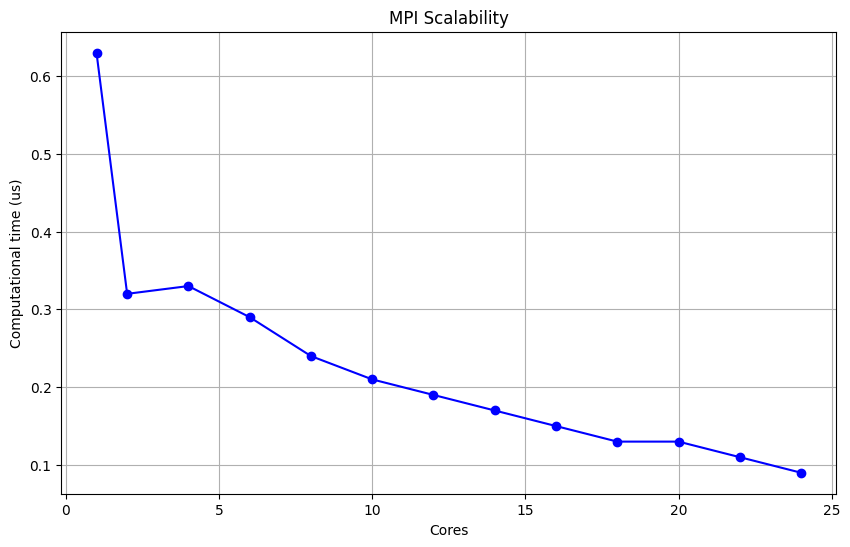

In [3]:
data = pd.read_csv('MPI_scaling1.csv', header=None, names=['MPI tasks', 'Computational time'])

cores = data['MPI tasks']
comp_time = data['Computational time']


plt.figure(figsize=(10, 6))
plt.plot(cores, comp_time, marker='o', color='b', linestyle='-')
plt.xlabel('Cores')
plt.ylabel('Computational time (us)')
plt.title('MPI Scalability')
plt.grid(True)
plt.show()